In [23]:
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCXGate
from qiskit.visualization import plot_histogram


def lights_out_oracle_2x2(initial_state):
    """
    initial_state : 초기 보드의 상태

    0~3: 토글 큐비트
    4~7: 보드 큐비트 (b-)
    """
    qc = QuantumCircuit(8, name="LightsOutOracle")  # 총 8 qubit 사용 (토글 4, 보드 4)
    
    # 1) 보드 레지스터(b4~b7)에 초기 상태 반영
    for i in range(4):
        if initial_state[i] == 1:
            qc.x(4 + i)  
    
    # 2) 토글 적용:
    #    t_i==1일 때, b_i 와 b_i에 인접한 램프를 뒤집는(토글) 연산 => CNOT(t_i -> b_j)
    adjacency = {
        0: [0, 1, 2],
        1: [1, 0, 3],
        2: [2, 0, 3],
        3: [3, 1, 2]
    }
    for toggle_bit in range(4):
        for board_bit in adjacency[toggle_bit]:
            qc.cx(toggle_bit, 4 + board_bit)

    # 3) b0,b1,b2,b3가 모두 0인지 검사 -> "모두 0이면 위상 플립" (MCZ)
    #    일반적 테크닉: X로 0->1 변환, 마지막 qubit에 H -> MCX -> H -> X 다시
    for qub in range(4, 8):
        qc.x(qub)
    qc.h(7)
    qc.mcx(list(range(4, 7)), 7)  # b4,b5,b6이 모두 1(= 원래 모두 0)이면 b7 위상 반전
    qc.h(7)
    for qub in range(4, 8):
        qc.x(qub)

    # 4) (2) 단계 되돌리기 (CNOT는 자기 자신이 역연산)
    #    uncompute: 같은 게이트를 역순(마지막부터) 적용
    for toggle_bit in reversed(range(4)):
        for board_bit in reversed(adjacency[toggle_bit]):
            qc.cx(toggle_bit, 4 + board_bit)

    # 5) (1) 단계도 복귀
    for i in range(4):
        if initial_state[i] == 1:
            qc.x(4 + i)
    
    return qc


def diffuser(num_qubits):
    """
    그로버 알고리즘에서 균등 초깃값(|+>^⊗n)에 대한 Diffuser
    (Inversion about the average).
    """
    diff = QuantumCircuit(num_qubits, name="Diffuser")
    diff.h(range(num_qubits))
    diff.x(range(num_qubits))

    # 다중제어 Z (여기서는 MCX = X타겟, H로 타겟 qubit를 Z로 변환)
    diff.h(num_qubits - 1)
    diff.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diff.h(num_qubits - 1)

    diff.x(range(num_qubits))
    diff.h(range(num_qubits))
    return diff


def grover_2x2_lightsout(initial_state, num_iterations):
    """
    2x2 Lights Out 문제에 그로버 알고리즘을 적용하는 메인 함수.
    
    - 토글 레지스터(0~3)만 초깃값 |+>로 만들어놓고 탐색.
    - 보드 레지스터(4~7)는 오라클에서만 임시 사용(ancilla처럼).
    """
    # 총 8 qubit: [0..3]=토글, [4..7]=보드
    qc = QuantumCircuit(8, 4)
    
    # 1) 토글 레지스터만 균등초깃값
    qc.h(range(4))
    
    # 2) Grover 반복
    oracle_circuit = lights_out_oracle_2x2(initial_state)
    diff_circuit = diffuser(4)  # 토글 레지스터용 Diffuser(4 qubit)
    
    for _ in range(num_iterations):
        qc.compose(oracle_circuit, qubits=range(8), inplace=True)
        qc.compose(diff_circuit, qubits=range(4), inplace=True)

    # 3) 토글 레지스터 측정
    qc.measure(range(4), range(4))
    
    # 시뮬레이터 실행
    backend = FakeKolkataV2()
    transpiled_qc = transpile(qc, backend)
    sampler = Sampler(backend)
    job = sampler.run([ (transpiled_qc, []) ], shots=4096)
    result = job.result()

    counts = result[0].data.c.get_counts()
    print("측정 결과:", counts)
    
    return qc, counts


측정 결과: {'0111': 236, '1101': 227, '1000': 594, '1011': 230, '0010': 225, '1100': 261, '1001': 227, '1111': 190, '0011': 239, '0000': 284, '0110': 221, '0100': 237, '1010': 248, '0001': 271, '1110': 195, '0101': 211}


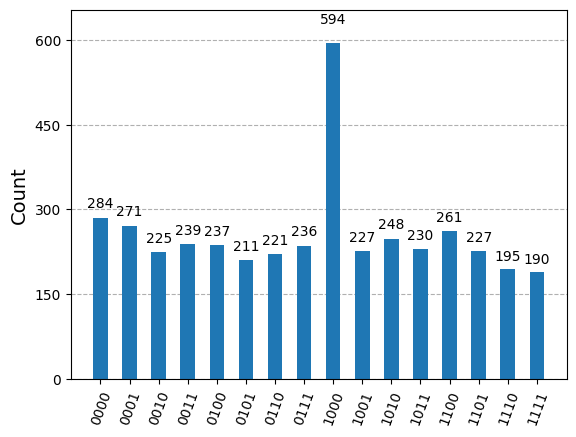

In [42]:
initial_state = (0, 0, 0, 1)

circuit, result_counts = grover_2x2_lightsout(initial_state, 2)

plot_histogram(result_counts)